# exp047
speed予測の検討（センサのみ） valid限定短縮版

In [1]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)

In [2]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [30]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [31]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [32]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [33]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [34]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [35]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [36]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [37]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

In [38]:
def add_features(df):
    for c,i in itertools.product(['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM'], [1,2,3,4,5,-1,-2,-3,-4,-5]):
        col = c+ '_s' + str(i)
        df[col] = df[c].shift(i)
        df[col+'_diff'] = df[c] - df[col]
        df.loc[df['phone']!=df['phone'].shift(i), [col, col+'_diff']] = np.nan
    
    for c in ['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM']:
        df[c+'_s1_diff_sum'] = df[c+'_s1_diff'].fillna(0) + df[c+'_s-1_diff'].fillna(0)
        df[c+'_s2_diff_sum'] = df[c+'_s1_diff_sum'] + df[c+'_s2_diff'].fillna(0) + df[c+'_s-2_diff'].fillna(0)
        df[c+'_s3_diff_sum'] = df[c+'_s2_diff_sum'] + df[c+'_s3_diff'].fillna(0) + df[c+'_s-3_diff'].fillna(0)
        df[c+'_s4_diff_sum'] = df[c+'_s3_diff_sum'] + df[c+'_s4_diff'].fillna(0) + df[c+'_s-4_diff'].fillna(0)
        df[c+'_s5_diff_sum'] = df[c+'_s4_diff_sum'] + df[c+'_s5_diff'].fillna(0) + df[c+'_s-5_diff'].fillna(0)
    
    return df

In [39]:
def add_sensor_features(df, accel, gyro, mag, ori):
    # phoneを追加
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    accel['phone'] = accel['collectionName'] + '_' + accel['phoneName']
    gyro['phone'] = gyro['collectionName'] + '_' + gyro['phoneName']
    mag['phone'] = mag['collectionName'] + '_' + mag['phoneName']
    ori['phone'] = ori['collectionName'] + '_' + ori['phoneName']
    
     # 一定の値しか入っていないphoneを除外しておく
    ori = ori[~ori['phone'].isin(['2021-04-29-US-MTV-1_SamsungS20Ultra', '2021-04-28-US-MTV-1_SamsungS20Ultra', '2021-04-28-US-SJC-1_SamsungS20Ultra', '2021-04-29-US-SJC-2_SamsungS20Ultra',
                                 '2021-04-28-US-MTV-2_SamsungS20Ultra', '2021-04-29-US-SJC-3_SamsungS20Ultra', '2021-04-29-US-MTV-2_SamsungS20Ultra'])]
    
    
    # phonenameをラベルエンコーディング
    phoneName_map = {'Pixel4':1, 'Pixel4XLModded':2, 'Pixel4XL':3, 'Mi8':4, 'Pixel4Modded':5, 'Pixel5':6, 'SamsungS20Ultra':7}
    df['phoneName_le'] = df['phoneName'].map(phoneName_map)
    
    # utc -> gps
    accel['millisSinceGpsEpoch'] = accel['utcTimeMillis'] - 315964800000 + 18000
    gyro['millisSinceGpsEpoch'] = gyro['utcTimeMillis'] - 315964800000 + 18000
    mag['millisSinceGpsEpoch'] = mag['utcTimeMillis'] - 315964800000 + 18000
    ori['millisSinceGpsEpoch'] = ori['utcTimeMillis'] - 315964800000 + 18000
    
    # resampling追加
    df['secondSinceGpsEpoch'] = df['millisSinceGpsEpoch'] // 1000
    accel['secondSinceGpsEpoch'] = accel['millisSinceGpsEpoch'] // 1000
    gyro['secondSinceGpsEpoch'] = gyro['millisSinceGpsEpoch'] // 1000
    mag['secondSinceGpsEpoch'] = mag['millisSinceGpsEpoch'] // 1000
    ori['secondSinceGpsEpoch'] = ori['millisSinceGpsEpoch'] // 1000
    
    # clipping
    accel[['UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2']] = accel.groupby('phone')['UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2'].transform(lambda x: x.clip(x.quantile(0.001), x.quantile(0.999)))
    gyro[['UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec']] = gyro.groupby('phone')['UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec'].transform(lambda x: x.clip(x.quantile(0.001), x.quantile(0.999)))
    mag[['UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT']] = mag.groupby('phone')['UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT'].transform(lambda x: x.clip(x.quantile(0.001), x.quantile(0.999)))
    
    accel = accel.groupby(['phone', 'secondSinceGpsEpoch'])['UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2'].agg(['mean', 'std']).reset_index()
    accel.columns = ['phone', 'secondSinceGpsEpoch', 'UncalAccelXMps2_mean', 'UncalAccelXMps2_std', 'UncalAccelYMps2_mean', 'UncalAccelYMps2_std', 'UncalAccelZMps2_mean', 'UncalAccelZMps2_std']
    gyro = gyro.groupby(['phone', 'secondSinceGpsEpoch'])['UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec'].agg(['mean', 'std']).reset_index()
    gyro.columns = ['phone', 'secondSinceGpsEpoch', 'UncalGyroXRadPerSec_mean', 'UncalGyroXRadPerSec_std', 'UncalGyroYRadPerSec_mean', 'UncalGyroYRadPerSec_std', 'UncalGyroZRadPerSec_mean', 'UncalGyroZRadPerSec_std' ]
    mag = mag.groupby(['phone', 'secondSinceGpsEpoch'])['UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT'].agg(['mean', 'std']).reset_index()
    mag.columns = ['phone', 'secondSinceGpsEpoch', 'UncalMagXMicroT_mean', 'UncalMagXMicroT_std', 'UncalMagYMicroT_mean', 'UncalMagYMicroT_std', 'UncalMagZMicroT_mean', 'UncalMagZMicroT_std']
    ori = ori.groupby(['phone', 'secondSinceGpsEpoch'])['yawDeg', 'rollDeg', 'pitchDeg'].agg(['mean', 'std']).reset_index()
    ori.columns = ['phone', 'secondSinceGpsEpoch', 'yawDeg_mean', 'yawDeg_std', 'rollDeg_mean', 'rollDeg_std', 'pitchDeg_mean', 'pitchDeg_std']
    
    
    # shift特徴量
    for c, i in itertools.product(['UncalAccelXMps2_mean', 'UncalAccelXMps2_std', 'UncalAccelYMps2_mean', 'UncalAccelYMps2_std', 'UncalAccelZMps2_mean', 'UncalAccelZMps2_std'], [1,2,3,4,5-1,-2,-3,-4,-5]):
        col = c+ '_s' + str(i)
        accel[col] = accel[c].shift(i)
        accel[col+'_diff'] = accel[c] - accel[col]
        accel.loc[accel['phone']!=accel['phone'].shift(i), [col, col+'_diff']] = np.nan
    for c, i in itertools.product(['UncalGyroXRadPerSec_mean', 'UncalGyroXRadPerSec_std', 'UncalGyroYRadPerSec_mean', 'UncalGyroYRadPerSec_std', 'UncalGyroZRadPerSec_mean', 'UncalGyroZRadPerSec_std'], [1,2,3,4,5-1,-2,-3,-4,-5]):
        col = c+ '_s' + str(i)
        gyro[col] = gyro[c].shift(i)
        gyro[col+'_diff'] = gyro[c] - gyro[col]
        gyro.loc[gyro['phone']!=gyro['phone'].shift(i), [col, col+'_diff']] = np.nan
    for c, i in itertools.product(['UncalMagXMicroT_mean', 'UncalMagXMicroT_std', 'UncalMagYMicroT_mean', 'UncalMagYMicroT_std', 'UncalMagZMicroT_mean', 'UncalMagZMicroT_std'], [1,2,3,4,5-1,-2,-3,-4,-5]):
        col = c+ '_s' + str(i)
        mag[col] = mag[c].shift(i)
        mag[col+'_diff'] = mag[c] - mag[col]
        mag.loc[mag['phone']!=mag['phone'].shift(i), [col, col+'_diff']] = np.nan
    for c, i in itertools.product(['yawDeg_mean', 'yawDeg_std', 'rollDeg_mean', 'rollDeg_std', 'pitchDeg_mean', 'pitchDeg_std'], [1,2,3,-1,-2,-3]):
        col = c+ '_s' + str(i)
        ori[col] = ori[c].shift(i)
        ori[col+'_diff'] = ori[c] - ori[col]
        ori.loc[ori['phone']!=ori['phone'].shift(i), [col, col+'_diff']] = np.nan        
    
    df = df.merge(accel, on=['phone', 'secondSinceGpsEpoch'], how='left')
    df = df.merge(gyro, on=['phone', 'secondSinceGpsEpoch'], how='left')
    df = df.merge(mag, on=['phone', 'secondSinceGpsEpoch'], how='left')
    df = df.merge(ori, on=['phone', 'secondSinceGpsEpoch'], how='left')
    
    df.drop(['secondSinceGpsEpoch'], axis=1, inplace=True)
    
    return df

In [40]:
train, test, sub, gt = get_data()
accel_train = pd.read_csv(INPUT + '/prep/gnss/train/UncalAccel.csv')
gyro_train = pd.read_csv(INPUT + '/prep/gnss/train/UncalGyro.csv')
mag_train = pd.read_csv(INPUT + '/prep/gnss/train/UncalMag.csv')
ori_train = pd.read_csv(INPUT + '/prep/gnss/train/OrientationDeg.csv')
accel_test = pd.read_csv(INPUT + '/prep/gnss/test/UncalAccel.csv')
gyro_test = pd.read_csv(INPUT + '/prep/gnss/test/UncalGyro.csv')
mag_test = pd.read_csv(INPUT + '/prep/gnss/test/UncalMag.csv')
ori_test = pd.read_csv(INPUT + '/prep/gnss/test/OrientationDeg.csv')

train = train.merge(gt[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'speedMps']], on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
train = add_sensor_features(train, accel_train, gyro_train, mag_train, ori_train)
test = add_sensor_features(test, accel_test, gyro_test, mag_test, ori_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Indexing with multiple k

In [41]:
target1 = 'speedMps'
not_use_cols = ['speedMps', 'courseDegree', 'collectionName', 'phoneName', 'phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM',
                'latDeg_s1', 'latDeg_s2', 'latDeg_s3', 'latDeg_s-1', 'latDeg_s-2',
                'latDeg_s-3', 'lngDeg_s1', 'lngDeg_s2', 'lngDeg_s3', 'lngDeg_s-1',
                'lngDeg_s-2', 'lngDeg_s-3', 'heightAboveWgs84EllipsoidM_s1',
                'heightAboveWgs84EllipsoidM_s2', 'heightAboveWgs84EllipsoidM_s3',
                'heightAboveWgs84EllipsoidM_s-1', 'heightAboveWgs84EllipsoidM_s-2',
                'heightAboveWgs84EllipsoidM_s-3']

features = [c for c in train.columns if c not in not_use_cols]

opt_params = {'objective': 'regression',
              'metrics': 'rmse',
              'learning_rate': 0.1, 
              'seed': 42, 
              'feature_pre_filter': False, 
              'lambda_l1': 5.430530747001109e-05, 
              'lambda_l2': 3.4066721259729875, 
              'num_leaves': 136, 
              'feature_fraction': 0.8999999999999999, 
              'bagging_fraction': 1.0, 
              'bagging_freq': 0, 
              'min_child_samples': 20, 
              'num_iterations': 20000, 
              'early_stopping_round': 100}

In [42]:
collections = ['2021-04-22-US-SJC-1', '2021-04-29-US-SJC-2', '2021-04-28-US-SJC-1']

oof1 = pd.DataFrame()
imp1 = pd.DataFrame()
test_preds = np.zeros(len(test))
n = len(collections)

for collection in collections:
    print('valid : ', collection)
    tr_idx = train[train['collectionName']!=collection].index
    vl_idx = train[train['collectionName']==collection].index
    tr_x, tr_y = train[features].iloc[tr_idx], train[target1].iloc[tr_idx]
    vl_x, vl_y = train[features].iloc[vl_idx], train[target1].iloc[vl_idx]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)
    
    model = lgb.train(opt_params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=20000, early_stopping_rounds=100, verbose_eval=100)
    vl_pred = model.predict(vl_x, num_iteration=model.best_iteration)
    
    oof_tmp = train.iloc[vl_idx].copy()
    oof_tmp['pred'] = vl_pred
    oof1 = oof1.append(oof_tmp)
    
    imp_tmp = pd.DataFrame()
    imp_tmp['feature'] = model.feature_name()
    imp_tmp['importance'] = model.feature_importance()
    imp_tmp['valid_collection'] = collection
    imp1 = imp1.append(imp_tmp)
    
    pred = model.predict(test[features], num_iteration=model.best_iteration)
    test_preds += pred / n
test['pred'] = test_preds

valid :  2021-04-22-US-SJC-1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97928
[LightGBM] [Info] Number of data points in the train set: 125626, number of used features: 385
[LightGBM] [Info] Start training from score 18.858086
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 5.2741	valid_1's rmse: 3.13216
[200]	training's rmse: 5.16341	valid_1's rmse: 3.09168
[300]	training's rmse: 5.1206	valid_1's rmse: 3.09326
Early stopping, best iteration is:
[230]	training's rmse: 5.14798	valid_1's rmse: 3.07793
valid :  2021-04-29-US-SJC-2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97928
[LightGBM] [Info] Number of data points in the train set: 126642, number of used features: 385
[LightGBM] [

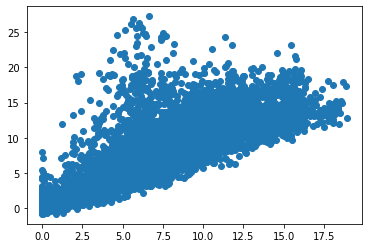

In [43]:
plt.scatter(oof1['speedMps'], oof1['pred'])

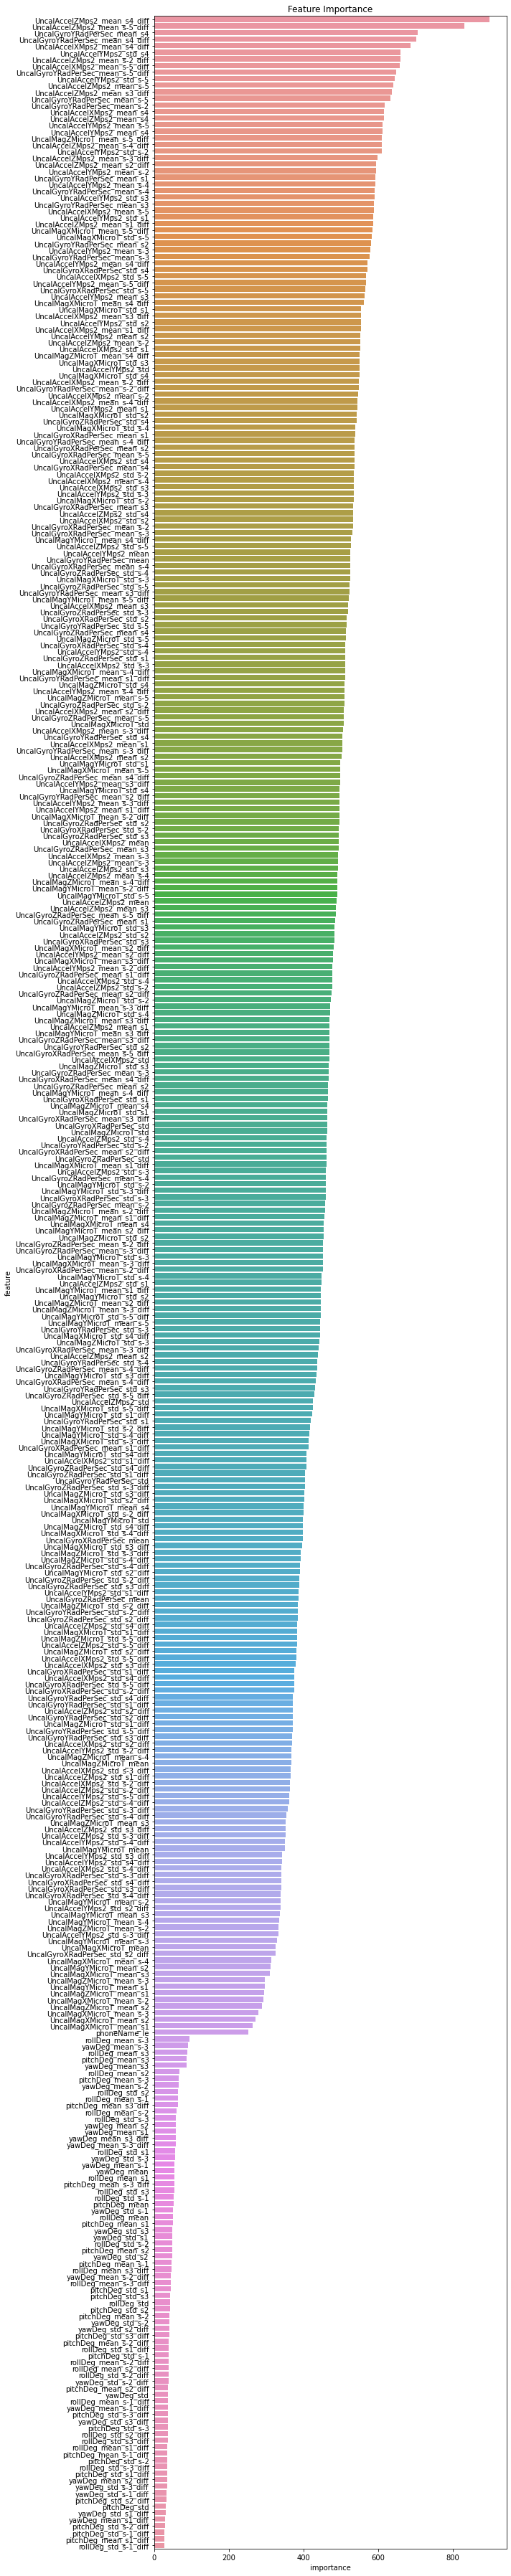

In [44]:
imp_mean = imp1.groupby('feature').mean().reset_index()
plt.figure(figsize=(10, 50))
sns.barplot(x="importance", y="feature", data=imp_mean.sort_values(by="importance", ascending=False))
plt.title("Feature Importance")
plt.tight_layout()

In [45]:
oof1[['collectionName', 'phoneName', 'phone', 'millisSinceGpsEpoch', 'pred']].to_csv(OUTPUT + '/train_distance_pred.csv', index=False)
test[['collectionName', 'phoneName', 'phone', 'millisSinceGpsEpoch', 'pred']].to_csv(OUTPUT + '/test_distance_pred.csv', index=False)

In [46]:
from sklearn.metrics import mean_squared_error
print('total : ', np.sqrt(mean_squared_error(oof1['speedMps'], oof1['pred'])))
phones = oof1['phone'].unique()
for phone in phones:
    tmp = oof1[oof1['phone']==phone].copy()
    print(phone + ' : ', np.sqrt(mean_squared_error(tmp['speedMps'], tmp['pred'])))

total :  2.2319951261978233
2021-04-22-US-SJC-1_Pixel4 :  1.7246932528026537
2021-04-22-US-SJC-1_SamsungS20Ultra :  4.014963073380707
2021-04-29-US-SJC-2_Pixel4 :  1.5795615321536476
2021-04-29-US-SJC-2_SamsungS20Ultra :  1.3801047620500577
2021-04-28-US-SJC-1_Pixel4 :  1.4029955622081327
2021-04-28-US-SJC-1_SamsungS20Ultra :  1.360867238810188


In [47]:
gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']

In [48]:
phones = oof1['phone'].unique()
for phone in phones:
    oof_tmp = oof1[oof1['phone']==phone].copy()
    gt_tmp = gt[gt['phone']==phone].copy()
    fig, axes = plt.subplots(figsize=(20, 5), nrows=1,sharex=True)
    axes.plot(oof_tmp['millisSinceGpsEpoch'], oof_tmp['pred'], label='pred')
    axes.plot(gt_tmp['millisSinceGpsEpoch'], gt_tmp['speedMps'], label='gt')
    axes.legend(loc='upper right')
    axes.grid(color='g', linestyle=':', linewidth=0.3)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(OUTPUT + '/' + phone + '.png')
    plt.close()